In [32]:
# The following lines enable automatic reloading of modules in an IPython/Jupyter environment.
# They work exactly like the commented lines below, but avoid errors when not running in such an environment.
# %load_ext autoreload
# %autoreload 2

try:
    # Only defined inside IPython/Jupyter
    get_ipython().run_line_magic("load_ext", "autoreload")
    get_ipython().run_line_magic("autoreload", "2")
except (NameError, AttributeError):
    # Not running in IPython → just ignore
    pass


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
# Initializing answer variable
answer = {}


In [34]:
# Some libs that we will use
import torch
import random
import numpy as np
import json_tricks
import lovely_tensors as lt
import matplotlib.pyplot as plt

# Making tensor printouts better
lt.monkey_patch()

# Adding sources to the pythonpath
import sys
root_path = '../../../..'
sys.path.append(root_path)

import dotenv
dotenv.load_dotenv(dotenv.find_dotenv(root_path + '/.env'))

# Importing sources of our project
import src


# Task 0: Prepare the environment

(Take care of reproducibility)

In [35]:
# YOUR CODE HERE
src.utils.seed.seed_all(0)

# Task 1: Prepare the data

We will use the same MNIST dataset, so just import it

In [36]:
from src.datasets.mnist_simple import MNISTSimpleDataset

## YOUR CODE HERE
MNIST_train = MNISTSimpleDataset(train=True)
MNIST_valid = MNISTSimpleDataset(train=False)


Check that the data is prepared:

In [37]:
with src.utils.safecatch():
    train_sample = MNIST_train[0]
    valid_sample = MNIST_valid[0]

    X_train = train_sample['image']
    X_valid = valid_sample['image']
    y_train = train_sample['label']
    y_valid = valid_sample['label']


In [38]:
with src.utils.safecatch():
    ## This checks are for dataset verification
    answer['X_train.dtype'] = str(X_train.dtype)
    answer['y_train.dtype'] = str(y_train.dtype)
    answer['X_valid.dtype'] = str(X_valid.dtype)
    answer['y_valid.dtype'] = str(y_valid.dtype)
    answer['X_train.shape'] = X_train.shape
    answer['X_valid.shape'] = X_valid.shape
    answer['y_train.shape'] = y_train.shape
    answer['y_valid.shape'] = y_valid.shape
    answer['X_train.mean'] = float(X_train.mean())
    answer['y_train.mean'] = float(y_train.float().mean())
    answer['X_valid.mean'] = float(X_valid.mean())
    answer['y_valid.mean'] = float(y_valid.float().mean())

    print(X_train.dtype, X_valid.dtype, y_train.dtype, y_valid.dtype)
    print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

    print(X_train)
    print(X_valid)
    print(y_train)
    print(y_valid)


torch.float32 torch.float32 torch.int64 torch.int64
torch.Size([28, 28]) torch.Size([28, 28]) torch.Size([]) torch.Size([])
tensor[28, 28] n=784 (3.1Kb) x∈[-1.000, 1.000] μ=-0.725 σ=0.625
tensor[28, 28] n=784 (3.1Kb) x∈[-1.000, 1.000] μ=-0.815 σ=0.518
tensor i64 5
tensor i64 7


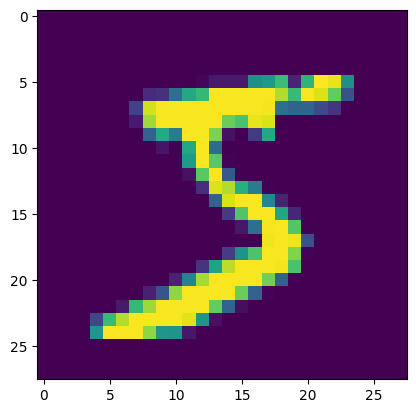

tensor i64 5


In [39]:
with src.utils.safecatch():
    plt.imshow(X_train)
    plt.show()
    print(y_train)


# Task 2: Build the code for the Autoencoder

This time we will build an autoencoder network that contains two parts:
- Encoder
- Decoder

Your task will be to build a model that contains two of these modules (each Fully-Connected Neural Network) having in mind that volume of Encoder should be exactly equal to the volume of the decoder.

Both encoder and decoder should have the same structure:
```bash
Linear
Activation
Linear     x N
Activation x N
Linear
```

The code should be done in `src/models/feedforward/autoencoders.py`

Number of linear and activation layers should be taken from the input list of channels.

For instance, if the list with channels is `[28*28, 128, 64]`, the encoder should look like:
```
28 * 28 -> Linear -> Activation -> 128 -> Linear -> Activation -> 64 -> Linear -> 64
```

The decoder should look like:
```
28 * 28 <- Linear <- 128 <- Activation <- Linear <- 64 <- Activation <- Linear <- 64
```

In this case the image is compressed into a vector of size 64

In [40]:
with src.utils.safecatch():
    ## Load your Autoencoder model
    ae_model = src.models.feedforward.autoencoder.Autoencoder([28 * 28, 128, 64])

    # Init the model for checking
    src.utils.deterministic_init(ae_model)


    check_input = {'image': torch.randn(10, 28 * 28)}
    with torch.no_grad():
        check_output = ae_model(check_input['image'])

        answer['check_result'] = src.utils.detach_copy(check_output)


# Task 3: Build Variational Autoencoder

The main difference between standard AutoEncoder and Variational AutoEncoder is that in Variational Autoencoder there is a reparametrization block (we will call it `sampler` in our network)

The idea is that this block computes $\mu$ and $\sigma$ from the input signal, and then samples the result from $\mathcal N (\mu, \sigma)$

Your task is to code this block.

Use linear layers to predict a tensor of $\mu$ and a tensor used to calculate $\sigma$ (without activation): $\mathbf z_\mu$, $\mathbf z_{\sigma}$
- `mu_regressor`
- `logvar_regressor`

After that, calculate:
- $\mu = \mathbf z_{\mu}$
- $\sigma = \exp(\frac{1}{2} \mathbf z_{\sigma})$

In the end, you should calculate the result as
- In case of training mode:
    $\mathbf z_{out} = \mu + \mathbf \epsilon * \sigma,$ where $\epsilon \propto \mathcal N (0, 1)$
- In case of evaluation mode:
    $\mathbf z_{out} = \mu$

Note that all the tensors, $\mu$, $\sigma$ and $\epsilon$ should have the same shape as the input tensor.

Add the abovecreated block in the middle of your Autoencoder to get VAE.

Note that VAE should return all of means and standard deviations together with result so that we are able to use them in the loss function.

In [41]:
with src.utils.safecatch():
    ## Load your VAE model
    vae_model = src.models.feedforward.autoencoder.VAE([28 * 28, 128, 64])

    # Init the model for checking
    # src.utils.deterministic_init(vae_model)


    check_input = {'image': torch.randn(10, 28 * 28)}
    with torch.no_grad():
        check_output = vae_model(check_input['image'])

        answer['check_result'] = src.utils.detach_copy(check_output)


# Task 3: Create loss function and optimizer



In this case we will use Adam with standard parameters as optimizer (`lr=1.0e-4` and weight decay `1.0e-4`)

As a loss function we will use MAE loss:

$L(\mathbf x^*, \mathbf x) = \frac{1}{S}\sum_{s=1}^S |x^*_s - x^s|,$

where index $s$ runs through all the pixels of all images (predicted and input)

Also create yet another loss function for regularization of the Variational AutoEncoder (VAE)

It works like this:

$L_{reg} = \frac{1}{2S}\sum_{s=1}^{S} (\mu_s^2 + \sigma_s^2 - \log \sigma_s^2 - 1)$

(this value is KL distance beteween normal distribution $\mathcal N (0, 1)$ and $\mathcal N (\mu_s, \sigma_s)$). What we are doing is we are training the model so that it minimizes the loss above, but does not deviate too much from univariate normal distribution.

The total loss function should be $L_{total} = L + \lambda L_{reg}$

Where $\lambda$ is regularization coefficient `reg_coeff`

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim

def loss(pred, targ):
    val = 0
    ## YOUR CODE HERE
    val = torch.mean(torch.abs(pred - targ))
    return val

def loss_reg(means, stds):
    val = 0
    ## YOUR CODE HERE
    kl_div = 0.5 * torch.sum(means.pow(2) + stds.pow(2) - torch.log(stds.pow(2)) - 1)
    val = kl_div / means.numel()
    return val

epochs = 10
lr = 1.0e-4
weight_decay = 1.0e-4
reg_coeff = 1.0  

optimizer_ae = optim.AdamW(ae_model.parameters(), lr=lr, weight_decay=weight_decay)
optimizer_vae = optim.AdamW(vae_model.parameters(), lr=lr, weight_decay=weight_decay)

## YOUR CODE HERE


In [43]:
with src.utils.safecatch():
    # Checking loss
    answer['loss_val'] = loss(torch.randn(5, 28, 28), torch.randn(5, 28, 28)).detach().numpy()
    answer['loss_reg_val'] = loss_reg(torch.randn(5, 28, 28), torch.randn(5, 28, 28).exp()).detach().numpy()

    # Adding optimizer to the checker
    answer['optimizer_ae'] = str(optimizer_ae)
    answer['optimizer_vae'] = str(optimizer_vae)
    print(optimizer_vae)


AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0.0001
)


# Task 4: Create DataLoaders

In [44]:
from tqdm import trange, tqdm
import neptune
import os

batch_size = 32
n_epochs = 10

## YOUR CODE HERE

train_dl = torch.utils.data.DataLoader(
    MNIST_train, 
    batch_size=batch_size, 
    num_workers=8,
    shuffle=True,
    pin_memory=True, 
    persistent_workers=True,
    drop_last=True)

valid_dl = torch.utils.data.DataLoader(
    MNIST_valid, 
    num_workers=8,
    batch_size=batch_size, 
    pin_memory=True, 
    persistent_workers=True,
    shuffle=False)


# Task 5: Create training loop

The task is the same:
- load samples batch-by-batch
- send the smaples through the model
- calculate loss function
- backpropagate the gradient
- step the optimizer
- perform validation to check overfitting

Create training cycles for AE and VAE

They share a lot of code and actually are different only in loss and returned values

You can try to join both of the training cycles, but not that it will require some code organization.

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [46]:
def calculate_psnr(pred, target, max_val=1.0):
    mse = torch.mean((pred - target) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * torch.log10(max_val / torch.sqrt(mse)).item()

def calculate_ssim(pred, target, window_size=11, size_average=True):
    mu_x = torch.mean(pred)
    mu_y = torch.mean(target)
    sigma_x = torch.std(pred)
    sigma_y = torch.std(target)
    sigma_xy = torch.mean((pred - mu_x) * (target - mu_y))
    
    C1 = (0.01 * 1.0) ** 2
    C2 = (0.03 * 1.0) ** 2
    
    ssim = ((2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)) / \
           ((mu_x ** 2 + mu_y ** 2 + C1) * (sigma_x ** 2 + sigma_y ** 2 + C2))
    
    return ssim.item()

In [ ]:
def train_model_ae(model, n_epochs, train_dl, valid_dl, loss, optimizer):
    train_loss_history = []
    valid_loss_history = []
    # peak signal-to-noise ratio 0-100, 100 - the best
    train_psnr_history = []
    valid_psnr_history = []
    # structure similarity -1-+1, +1 - the best
    train_ssim_history = []
    valid_ssim_history = []

    ## STARTING THE TRACKER (neptune.ai, mlflow, tensorboard, etc)
    # run = neptune.init_run(
    #     ## YOUR CODE HERE
    # )

    for epoch in trange(n_epochs):
        train_loss = {'enumerator': 0.0, 'denominator': 1.0e-8}

        train_psnr = {'enumerator': 0.0, 'denominator': 1.0e-8}
        train_ssim = {'enumerator': 0.0, 'denominator': 1.0e-8}

        for batch in tqdm(train_dl):
            ## YOUR TRAINING CODE HERE
            inputs = batch['image']
            targets = batch['label']
            
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                targets = targets.cuda()

            optimizer.zero_grad()
            reconstruction = model(inputs)
            batch_loss = loss(reconstruction, inputs)

            batch_loss.backward()
            optimizer.step()

            with torch.no_grad():
                batch_psnr = calculate_psnr(reconstruction, inputs)
                batch_ssim = calculate_ssim(reconstruction, inputs)
            
            batch_size = inputs.size(0)
            train_loss['enumerator'] += batch_loss.item() * batch_size
            train_loss['denominator'] += batch_size

            train_psnr['enumerator'] += batch_psnr * batch_size
            train_psnr['denominator'] += batch_size
            train_ssim['enumerator'] += batch_ssim * batch_size
            train_ssim['denominator'] += batch_size

        with torch.no_grad():
            model.eval()
            valid_loss = {'enumerator': 0.0, 'denominator': 1.0e-8}

            valid_psnr = {'enumerator': 0.0, 'denominator': 1.0e-8}
            valid_ssim = {'enumerator': 0.0, 'denominator': 1.0e-8}

            for valid_batch in tqdm(valid_dl):
                ## YOUR EVALUATION CODE HERE
                inputs = batch['image']
                targets = batch['label']

                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                    targets = targets.cuda()
                
                reconstruction = model(inputs)
                batch_loss = loss(reconstruction, inputs)

                batch_psnr = calculate_psnr(reconstruction, inputs)
                batch_ssim = calculate_ssim(reconstruction, inputs)
                
                batch_size = inputs.size(0)
                valid_loss['enumerator'] += batch_loss.item() * batch_size
                valid_loss['denominator'] += batch_size

                valid_psnr['enumerator'] += batch_psnr * batch_size
                valid_psnr['denominator'] += batch_size
                valid_ssim['enumerator'] += batch_ssim * batch_size
                valid_ssim['denominator'] += batch_size


            finalized_train_loss = train_loss['enumerator'] / train_loss['denominator']
            finalized_valid_loss = valid_loss['enumerator'] / valid_loss['denominator']

            finalized_train_psnr = train_psnr['enumerator'] / train_psnr['denominator']
            finalized_valid_psnr = valid_psnr['enumerator'] / valid_psnr['denominator']
            finalized_train_ssim = train_ssim['enumerator'] / train_ssim['denominator']
            finalized_valid_ssim = valid_ssim['enumerator'] / valid_ssim['denominator']

            # Logging the progress to neptune (or mlflow/tensorboard)
            # run["ae/train_loss"].log(finalized_train_loss)
            # run["ae/valid_loss"].log(finalized_valid_loss)

            train_loss_history.append(finalized_train_loss)
            valid_loss_history.append(finalized_valid_loss)

            train_psnr_history.append(finalized_train_psnr)
            valid_psnr_history.append(finalized_valid_psnr)
            train_ssim_history.append(finalized_train_ssim)
            valid_ssim_history.append(finalized_valid_ssim)

            print(f"AE Epoch {epoch+1}: Train Loss: {finalized_train_loss:.4f}, Valid Loss: {finalized_valid_loss:.4f}")
            print(f"AE Epoch {epoch+1}: Train PSNR: {finalized_train_psnr:.4f}, Valid PSNR: {finalized_valid_psnr:.4f}")
            print(f"AE Epoch {epoch+1}: Train SSIM: {finalized_train_ssim:.4f}, Valid SSIM: {finalized_valid_ssim:.4f}")

    # Stopping your experiment tracker if you have some
    # run.stop()
    return train_loss_history, valid_loss_history

with src.utils.safecatch():
    train_loss_history_ae, valid_loss_history_ae = train_model_ae(ae_model, n_epochs, train_dl, valid_dl, loss, optimizer_ae)
    # train_loss_history_ae, valid_loss_history_ae = None, None


In [ ]:
def train_model_vae(model, n_epochs, train_dl, valid_dl, loss, optimizer, reg_coeff=0.1):
    train_loss_history = []
    valid_loss_history = []
    # peak signal-to-noise ratio 0-100, 100 - the best
    train_psnr_history = []
    valid_psnr_history = []
    # structure similarity -1-+1, +1 - the best
    train_ssim_history = []
    valid_ssim_history = []

    train_recon_history = []
    train_reg_history = []
    valid_recon_history = []
    valid_reg_history = []

    ## STARTING THE TRACKER (neptune.ai, mlflow, tensorboard, etc)
    # run = neptune.init_run(
    #     ## YOUR CODE HERE
    # )

    for epoch in trange(n_epochs):
        train_loss = {'enumerator': 0.0, 'denominator': 1.0e-8}
        train_recon = {'enumerator': 0.0, 'denominator': 1.0e-8}
        train_reg = {'enumerator': 0.0, 'denominator': 1.0e-8}
        
        train_psnr = {'enumerator': 0.0, 'denominator': 1.0e-8}
        train_ssim = {'enumerator': 0.0, 'denominator': 1.0e-8}

        for batch in train_dl:
            ## YOUR TRAINING CODE HERE
            inputs = batch['image']
            targets = batch['label']
            
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                targets = targets.cuda()

            optimizer.zero_grad()
            # reconstruction = model(inputs)
            # batch_loss = loss(reconstruction, inputs)

            reconstruction, means, stds = model(inputs)
            recon_loss = loss(reconstruction, inputs)
            reg_loss = loss_reg(means, stds)
            batch_loss = recon_loss + reg_coeff * reg_loss

            batch_loss.backward()
            optimizer.step()

            with torch.no_grad():
                batch_psnr = calculate_psnr(reconstruction, inputs)
                batch_ssim = calculate_ssim(reconstruction, inputs)
            
            batch_size = inputs.size(0)
            train_loss['enumerator'] += batch_loss.item() * batch_size
            train_loss['denominator'] += batch_size
            train_recon['enumerator'] += recon_loss.item() * batch_size
            train_recon['denominator'] += batch_size
            train_reg['enumerator'] += reg_loss.item() * batch_size
            train_reg['denominator'] += batch_size
            
            train_psnr['enumerator'] += batch_psnr * batch_size
            train_psnr['denominator'] += batch_size
            train_ssim['enumerator'] += batch_ssim * batch_size
            train_ssim['denominator'] += batch_size

        with torch.no_grad():
            valid_loss = {'enumerator': 0.0, 'denominator': 1.0e-8}
            valid_recon = {'enumerator': 0.0, 'denominator': 1.0e-8}
            valid_reg = {'enumerator': 0.0, 'denominator': 1.0e-8}

            valid_psnr = {'enumerator': 0.0, 'denominator': 1.0e-8}
            valid_ssim = {'enumerator': 0.0, 'denominator': 1.0e-8}
            for valid_batch in valid_dl:
                ## YOUR EVALUATION CODE HERE
                inputs = batch['image']
                targets = batch['label']

                if torch.cuda.is_available():
                    inputs = inputs.cuda()
                    targets = targets.cuda()
                
                # reconstruction = model(inputs)
                # batch_loss = loss(reconstruction, inputs)

                reconstruction, means, stds = model(inputs)
                recon_loss = loss(reconstruction, inputs)
                reg_loss = loss_reg(means, stds)
                batch_loss = recon_loss + reg_coeff * reg_loss

                batch_psnr = calculate_psnr(reconstruction, inputs)
                batch_ssim = calculate_ssim(reconstruction, inputs)

                batch_size = inputs.size(0)
                valid_loss['enumerator'] += batch_loss.item() * batch_size
                valid_loss['denominator'] += batch_size
                valid_recon['enumerator'] += recon_loss.item() * batch_size
                valid_recon['denominator'] += batch_size
                valid_reg['enumerator'] += reg_loss.item() * batch_size
                valid_reg['denominator'] += batch_size

                valid_psnr['enumerator'] += batch_psnr * batch_size
                valid_psnr['denominator'] += batch_size
                valid_ssim['enumerator'] += batch_ssim * batch_size
                valid_ssim['denominator'] += batch_size

            finalized_train_loss = train_loss['enumerator'] / train_loss['denominator']
            finalized_valid_loss = valid_loss['enumerator'] / valid_loss['denominator']
            finalized_train_recon = train_recon['enumerator'] / train_recon['denominator']
            finalized_valid_recon = valid_recon['enumerator'] / valid_recon['denominator']
            finalized_train_reg = train_reg['enumerator'] / train_reg['denominator']
            finalized_valid_reg = valid_reg['enumerator'] / valid_reg['denominator']

            finalized_train_psnr = train_psnr['enumerator'] / train_psnr['denominator']
            finalized_valid_psnr = valid_psnr['enumerator'] / valid_psnr['denominator']
            finalized_train_ssim = train_ssim['enumerator'] / train_ssim['denominator']
            finalized_valid_ssim = valid_ssim['enumerator'] / valid_ssim['denominator']

            # Logging the progress to neptune (or mlflow/tensorboard)

            train_loss_history.append(finalized_train_loss)
            valid_loss_history.append(finalized_valid_loss)
            train_recon_history.append(finalized_train_recon)
            valid_recon_history.append(finalized_valid_recon)
            train_reg_history.append(finalized_train_reg)
            valid_reg_history.append(finalized_valid_reg)

            train_psnr_history.append(finalized_train_psnr)
            valid_psnr_history.append(finalized_valid_psnr)
            train_ssim_history.append(finalized_train_ssim)
            valid_ssim_history.append(finalized_valid_ssim)

            print(f"МAE Epoch {epoch+1}: Train Loss:  {finalized_train_loss:.4f}, Valid Loss:  {finalized_valid_loss:.4f}")
            print(f"VAE Epoch {epoch+1}: Train Recon: {finalized_train_reg:.4f},  Valid Recon: {finalized_valid_recon:.4f}")
            print(f"VAE Epoch {epoch+1}: Train Reg:   {finalized_train_reg:.4f},  Valid Reg:   {finalized_valid_reg:.4f}") 
            print(f"МAE Epoch {epoch+1}: Train PSNR:  {finalized_train_psnr:.4f}, Valid PSNR:  {finalized_valid_psnr:.4f}")
            print(f"МAE Epoch {epoch+1}: Train SSIM:  {finalized_train_ssim:.4f}, Valid SSIM:  {finalized_valid_ssim:.4f}")

    # Stopping your experiment tracker if you have some
    # run.stop()
    return train_loss_history, valid_loss_history

with src.utils.safecatch():
    train_loss_history_vae, valid_loss_history_vae = train_model_vae(vae_model, n_epochs, train_dl, valid_dl, loss, optimizer_vae)
    # train_loss_history_vae, valid_loss_history_vae = None, None


In [49]:
with src.utils.safecatch():
    answer['train_loss_history_ae'] = train_loss_history_ae
    answer['valid_loss_history_ae'] = valid_loss_history_ae

    answer['train_loss_history_vae'] = train_loss_history_vae
    answer['valid_loss_history_vae'] = valid_loss_history_vae

json_tricks.dump(answer, '.answer.json')


'{"X_train.dtype": "torch.float32", "y_train.dtype": "torch.int64", "X_valid.dtype": "torch.float32", "y_valid.dtype": "torch.int64", "X_train.shape": [28, 28], "X_valid.shape": [28, 28], "y_train.shape": [], "y_valid.shape": [], "X_train.mean": -0.7246397137641907, "y_train.mean": 5.0, "X_valid.mean": -0.815386176109314, "y_valid.mean": 7.0, "check_result": [{"__ndarray__": [[0.007749341428279877, -0.29796522855758667, -0.1737738400697708, 0.171362966299057, -0.23178085684776306, -0.19630317389965057, -0.24202784895896912, -0.19202867150306702, -0.32696571946144104, 0.43053969740867615, 0.17042401432991028, 0.10080942511558533, -0.026138432323932648, 0.011666633188724518, 0.10181591659784317, 0.08187946677207947, -0.22222359478473663, 0.17837995290756226, 0.15499958395957947, -0.20195302367210388, -0.01006510853767395, -0.19382613897323608, 0.17344725131988525, 0.03291217237710953, -0.005723554641008377, -0.20132465660572052, 0.3245123624801636, 0.44783806800842285, -0.283986091613769

# Task 7. Experiment time!

The code below is commented -- slowly uncomment it trying to understand, what is happenning

Create a new autoencoder model and train it for 150 epochs (or more if you like)

In [50]:
# n_epochs = 150
# model_ae = src.models.feedforward.autoencoder.Autoencoder([28 * 28, 128, 64])
# optimizer_ae = torch.optim.Adam(model_ae.parameters(), lr=1.0e-3, weight_decay=1.0e-8)

# train_loss_history, valid_loss_history = train_model_ae(model_ae, n_epochs, train_dl, valid_dl, loss, optimizer_ae)


After you're done, you can elaborate on the experiments. The taks is to make the reconstruction as good as possible meanwhile forcing the network to generalize between the concepts. That means that if you have a linear interpolation between two embeddings, you should have a continuous sequence of something that at least distantly resembles a digit.

The last will be extremely hard to achieve with simple AE.

In [51]:
# with torch.no_grad():
#     img1 = MNIST_valid[0]['image']
#     img2 = MNIST_valid[1]['image']

#     plt.figure()
#     plt.imshow(img1.reshape([28, 28]))
#     plt.figure()
#     plt.imshow(img2.reshape([28, 28]))

#     emb1 = model_ae.encoder(img1.reshape([1, -1]))
#     emb2 = model_ae.encoder(img2.reshape([1, -1]))

#     rec1 = model_ae.decoder(emb1)
#     rec2 = model_ae.decoder(emb2)

#     plt.figure()
#     plt.imshow(rec1.reshape([28, 28]))
#     plt.figure()
#     plt.imshow(rec2.reshape([28, 28]))


In [52]:
# figures = []

# with torch.no_grad():
#     for a in np.linspace(0, 1, 10):
#         rec = model_ae.decoder(a * emb1 + (1 - a) * emb2)
#         figures.append(rewhat c.reshape([28, 28]))

# plt.figure(figsize=(10, 10))
# plt.imshow(np.concatenate(figures, axis=1))


As you can see, the standard AE does not mix the entities, it mixes the images.

Now try to achieve the same task with VAE. Start with regularization $10^{-1}$ and then try to find the configuration, where your network is mixing the concepts the best. Obviously, if you make regularization term equal exactly to $0$, you will have exact Autoencoder behavior. 

In [53]:
# n_epochs = 50
# model_vae = src.models.feedforward.autoencoder.VAE([28 * 28, 128, 64])
# optimizer_vae = torch.optim.Adam(model_vae.parameters(), lr=1.0e-3, weight_decay=1.0e-8)

# train_loss_history, valid_loss_history = train_model_vae(model_vae, n_epochs, train_dl, valid_dl, loss, optimizer_vae)


In [54]:
# with torch.no_grad():
#     img1 = MNIST_valid[0]['image']
#     img2 = MNIST_valid[1]['image']

#     plt.figure()
#     plt.imshow(img1.reshape([28, 28]))
#     plt.figure()
#     plt.imshow(img2.reshape([28, 28]))

#     emb1 = model_vae.encoder(img1.reshape([1, -1]))
#     emb2 = model_vae.encoder(img2.reshape([1, -1]))

#     emb1, _, _ = model_vae.sampler(emb1)
#     emb2, _, _ = model_vae.sampler(emb2)

#     rec1 = model_vae.decoder(emb1)
#     rec2 = model_vae.decoder(emb2)

#     plt.figure()
#     plt.imshow(rec1.reshape([28, 28]))
#     plt.figure()
#     plt.imshow(rec2.reshape([28, 28]))


In [55]:
# figures = []

# with torch.no_grad():
#     for a in np.linspace(0, 1, 10):
#         rec = model_vae.decoder(a * emb1 + (1 - a) * emb2)
#         figures.append(rec.reshape([28, 28]))

# plt.figure(figsize=(10, 10))
# plt.imshow(np.concatenate(figures, axis=1))


As we can see, after inclusion of variation into the autoencoder at least tries to mix the concepts of different patterns